# Deep learning sentence classification

## SpoilerBlockerAI Subproject

In [19]:
# Imports

from keras import layers
from keras.models import Sequential
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers import Conv1D, LSTM
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [2]:
# Loading data
df = pd.read_csv("csvCut/goodreads49k39percentSHUFFLE.csv", nrows=49000)

df.head()

,Unnamed: 0,has_spoiler,sentence
0,0,1,son of a bitch!
1,1,0,Every single time we refused to cave in to our...
2,2,0,And Everly had both of these qualities in spad...
3,3,0,"For what it is, it is a pleasant enough read -..."
4,4,1,They say the same saying.


In [3]:
df.isnull().values.any()

False

In [4]:
# Data definition

sentences = list(df['sentence'].apply(lambda s: s.lower()))
spoilers = np.array(df["has_spoiler"])

print(len(sentences))
print(f"\n{sentences[5]}")

49000

i liked this idea a lot, especially how they descended from the alchemists.


In [5]:
X_train, X_test, y_train, y_test = train_test_split(sentences, spoilers, test_size=0.30, random_state=42)

In [6]:
# Data preparation

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('embeddings/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


## Simple neural network

In [7]:
# Model preparation

model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2454100   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 10001     
Total params: 2,464,101
Trainable params: 10,001
Non-trainable params: 2,454,100
_________________________________________________________________


In [9]:
# Training the model

history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
215/215 [==============================] - 1s 4ms/step - loss: 0.6491 - acc: 0.6169 - val_loss: 0.6200 - val_acc: 0.6474
Epoch 2/10
215/215 [==============================] - 1s 3ms/step - loss: 0.5965 - acc: 0.6655 - val_loss: 0.6171 - val_acc: 0.6468
Epoch 3/10
215/215 [==============================] - 1s 3ms/step - loss: 0.5871 - acc: 0.6757 - val_loss: 0.6139 - val_acc: 0.6577
Epoch 4/10
215/215 [==============================] - 1s 3ms/step - loss: 0.5746 - acc: 0.6875 - val_loss: 0.6177 - val_acc: 0.6551
Epoch 5/10
215/215 [==============================] - 1s 5ms/step - loss: 0.5710 - acc: 0.6884 - val_loss: 0.6155 - val_acc: 0.6569
Epoch 6/10
215/215 [==============================] - 1s 5ms/step - loss: 0.5676 - acc: 0.6902 - val_loss: 0.6207 - val_acc: 0.6538
Epoch 7/10
215/215 [==============================] - 1s 5ms/step - loss: 0.5581 - acc: 0.7013 - val_loss: 0.6284 - val_acc: 0.6494
Epoch 8/10
215/215 [==============================] - 1s 5ms/step - loss: 0.

In [10]:
# Predicting spoilers

score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

460/460 [==============================] - 1s 2ms/step - loss: 0.6182 - acc: 0.6587
Test Score: 0.6182236671447754
Test Accuracy: 0.6587074995040894


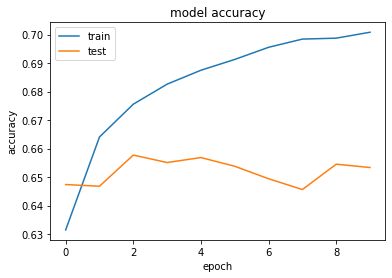

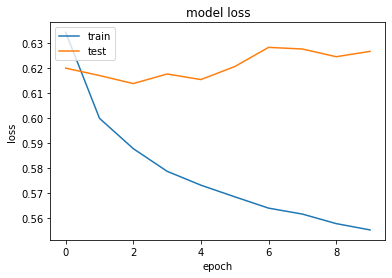

In [11]:
# Plotting model's loss and accuracy on train and test data for each epoch

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Convolutional neural network

In [15]:
# Convolutial neural network model preparation

model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          2454100   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,518,357
Trainable params: 64,257
Non-trainable params: 2,454,100
_________________________________________________________________


In [16]:
# Fit and predict

history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Epoch 1/6
215/215 [==============================] - 12s 50ms/step - loss: 0.6352 - acc: 0.6361 - val_loss: 0.5848 - val_acc: 0.6810
Epoch 2/6
215/215 [==============================] - 10s 47ms/step - loss: 0.5576 - acc: 0.7061 - val_loss: 0.5719 - val_acc: 0.6920
Epoch 3/6
215/215 [==============================] - 12s 55ms/step - loss: 0.5153 - acc: 0.7427 - val_loss: 0.5675 - val_acc: 0.6966
Epoch 4/6
215/215 [==============================] - 11s 51ms/step - loss: 0.4805 - acc: 0.7678 - val_loss: 0.5589 - val_acc: 0.7015
Epoch 5/6
215/215 [==============================] - 10s 47ms/step - loss: 0.4371 - acc: 0.8024 - val_loss: 0.5807 - val_acc: 0.6832
Epoch 6/6
460/460 [==============================] - 3s 5ms/step - loss: 0.5713 - acc: 0.6982
Test Score: 0.5713182091712952
Test Accuracy: 0.6981632709503174


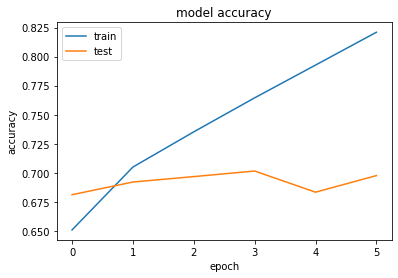

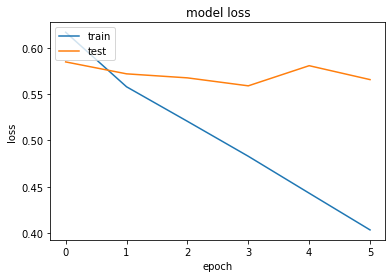

In [17]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Recurrent neural network (LSTM)

In [20]:
# Recurrent neural network model preparation

model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          2454100   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 2,571,477
Trainable params: 117,377
Non-trainable params: 2,454,100
_________________________________________________________________
Epoch 1/6
215/215 [==============================] - 43s 192ms/step - loss: 0.6753 - acc: 0.5984 - val_loss: 0.6692 - val_acc: 0.6099
Epoch 2/6
215/215 [==============================] - 43s 198ms/step - loss: 0.6715 - acc: 0.6038 - val_loss: 0.6699 - val_acc: 0.6099
Epoch 3/6
215/215 [==============================] - 43s 199ms/step - loss: 0.6725 - acc: 0.6016 - v

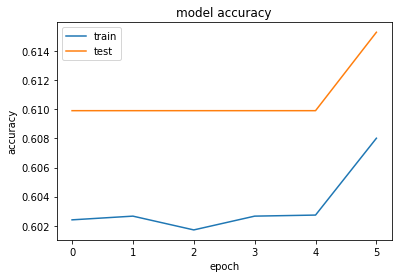

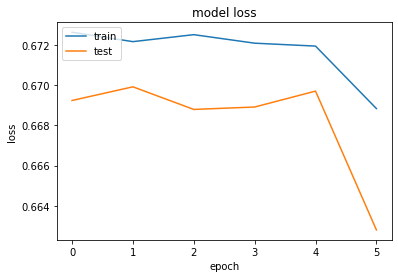

In [21]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()